In [1]:
# Importing all the necessary libraries needed throughout the study
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
import numpy as np
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df =pd.read_csv(r"C:\\Users\\90537\\Desktop\\Subject10_eeg_2.csv")
df = df[(df["TimeStamp"] >= 2) & (df["TimeStamp"] < 5)]
df['segment'] = (((df['TimeStamp'] // 1) - 1) + (df['trial'] - 1) * 3).astype(int)
df

,TimeStamp,F3,Fz,F4,FC5,FC1,FC2,FC6,T7,C3,C4,Cz,T8,CP5,CP1,CP2,CP6,trial,class,segment
1249,2.000,-6.833240,-6.981946,-6.992199,-4.644892,-6.209523,-5.463709,-6.874524,-5.251305,-5.726822,-6.829862,-3.800808,-6.736063,-4.908157,-3.455084,-3.603567,-7.195244,1,-1,1
1250,2.004,-6.331014,-8.568129,-6.709601,-3.559943,-5.902237,-6.646989,-5.732202,-4.188257,-5.080477,-7.618693,-3.710517,-5.543705,-3.167940,-2.255586,-2.338839,-6.139860,1,-1,1
1251,2.008,-3.987513,-8.611999,-4.680145,-0.543010,-4.432592,-6.305791,-2.992598,-1.069440,-3.516001,-6.327579,-2.412802,-2.791251,-0.848699,-0.155190,-0.101705,-3.433923,1,-1,1
1252,2.012,-1.674875,-8.863270,-2.987031,2.684697,-3.719515,-6.185693,-0.760135,2.345745,-2.810466,-4.352659,-1.742409,-0.579361,0.801024,1.011419,1.360308,-1.154763,1,-1,1
1253,2.016,-0.878734,-10.598063,-3.424601,4.535047,-4.776806,-7.703256,-0.662398,4.415371,-3.805408,-3.494799,-2.861879,-0.448679,1.217109,0.135083,0.863944,-0.832153,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,4.980,5.146679,14.819276,10.562358,-4.074375,7.521707,13.522714,3.509746,-3.774681,5.483693,6.604632,4.641065,3.957108,-3.829359,-1.177648,3.435993,3.805722,40,1,120
79995,4.984,5.674007,15.212426,11.004676,-3.937553,7.374117,13.875340,4.698561,-3.591195,5.581105,7.320370,3.330541,4.994607,-4.802689,-2.383966,2.834542,4.880152,40,1,120
79996,4.988,6.462724,16.075073,11.525469,-2.473118,8.099219,14.799914,5.456638,-2.030018,6.620478,7.963983,3.044437,5.596353,-4.432163,-2.644213,2.520539,5.439181,40,1,120
79997,4.992,7.008338,16.750555,11.361969,-0.483749,9.164109,15.541871,5.254177,0.081853,7.949434,8.055797,3.591997,5.298492,-3.185637,-2.129231,2.436072,5.081256,40,1,120


In [21]:
# processing, segmenting and extracting band powers of calibration and feedback dfs to create train and test datasets
test1_dfs = []
test2_dfs = []
test3_dfs = []

feedback1_dfs = [
    r"C:\\Users\\90537\\Desktop\\Subject10_eeg_2.csv",
    r"C:\\Users\\90537\\Desktop\\Subject11_eeg_2.csv",
    r"C:\\Users\\90537\\Desktop\\Subject12_eeg_2.csv",
    r"C:\\Users\\90537\\Desktop\\Subject13_eeg_2.csv",
    r"C:\\Users\\90537\\Desktop\\Subject14_eeg_2.csv"
]
feedback2_dfs = [
    r"C:\\Users\\90537\\Desktop\\Subject10_eeg_3.csv",
    r"C:\\Users\\90537\\Desktop\\Subject11_eeg_3.csv",
    r"C:\\Users\\90537\\Desktop\\Subject12_eeg_3.csv",
    r"C:\\Users\\90537\\Desktop\\Subject13_eeg_3.csv",
    r"C:\\Users\\90537\\Desktop\\Subject14_eeg_3.csv"
]
feedback3_dfs = [
    r"C:\\Users\\90537\\Desktop\\Subject10_eeg_4.csv",
    r"C:\\Users\\90537\\Desktop\\Subject11_eeg_4.csv",
    r"C:\\Users\\90537\\Desktop\\Subject12_eeg_4.csv",
    r"C:\\Users\\90537\\Desktop\\Subject13_eeg_4.csv",
    r"C:\\Users\\90537\\Desktop\\Subject14_eeg_4.csv"
]

def band_power(data):
    frequency_bands = {
        'DELTA': [0.5, 3.5],
        'THETA': [4, 7],
        'ALPHA': [8, 13],
        'BETA': [13, 25],
        'GAMMA': [25, 48]
    }
    fs = 250
    results = {}
    for column in data.columns:
        x = data[column].values
        frequencies, psd = signal.welch(x, fs, nperseg=1024)
        for band, freqrange in frequency_bands.items():
            freq_indices = np.logical_and(frequencies >= freqrange[0], frequencies <= freqrange[1])
            p = np.trapz(psd[freq_indices], frequencies[freq_indices])
            results[f"{band}_{column}"] = p
    return pd.DataFrame([results])

# processing test dataset 1
for feedback1_df in feedback1_dfs:
    subject_df = pd.read_csv(feedback1_df)
    motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 2) & (subject_df["TimeStamp"] < 5)]
    motor_imagery_subject_df['segment'] = (((motor_imagery_subject_df['TimeStamp'] // 1) - 1) + (motor_imagery_subject_df['trial'] - 1) * 3).astype(int)
    labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
    motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

    segment_band_powers = []
    for segment in motor_imagery_subject_df['segment'].unique():
        segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
        band_powers = band_power(segment_data)
        segment_band_powers.append(band_powers)
  
    test1_dataset = pd.concat(segment_band_powers, ignore_index=True)
    test1_dataset["label"] = labels
    test1_dfs.append(test1_dataset)

# processing test dataset 2
for feedback2_df in feedback2_dfs:
    subject_df = pd.read_csv(feedback2_df)
    motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 2) & (subject_df["TimeStamp"] < 5)]
    motor_imagery_subject_df['segment'] = (((motor_imagery_subject_df['TimeStamp'] // 1) - 1) + (motor_imagery_subject_df['trial'] - 1) * 3).astype(int)
    labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
    motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

    segment_band_powers = []
    for segment in motor_imagery_subject_df['segment'].unique():
        segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
        band_powers = band_power(segment_data)
        segment_band_powers.append(band_powers)
  
    test2_dataset = pd.concat(segment_band_powers, ignore_index=True)
    test2_dataset["label"] = labels
    test2_dfs.append(test2_dataset)

# processing test dataset 3
for feedback3_df in feedback3_dfs:
    subject_df = pd.read_csv(feedback3_df)
    motor_imagery_subject_df = subject_df[(subject_df["TimeStamp"] >= 2) & (subject_df["TimeStamp"] < 5)]
    motor_imagery_subject_df['segment'] = (((motor_imagery_subject_df['TimeStamp'] // 1) - 1) + (motor_imagery_subject_df['trial'] - 1) * 3).astype(int)
    labels = motor_imagery_subject_df.groupby('segment')['class'].first().values
    motor_imagery_subject_df = motor_imagery_subject_df.drop(["TimeStamp", "trial", "class"], axis=1)

    segment_band_powers = []
    for segment in motor_imagery_subject_df['segment'].unique():
        segment_data = motor_imagery_subject_df[motor_imagery_subject_df['segment'] == segment].drop(columns=['segment'])
        band_powers = band_power(segment_data)
        segment_band_powers.append(band_powers)
  
    test3_dataset = pd.concat(segment_band_powers, ignore_index=True)
    test3_dataset["label"] = labels
    test3_dfs.append(test3_dataset)

In [32]:
merged_list = []
for i in range(len(test1_dfs)):
    merged_list.append(pd.concat([test1_dfs[i], test2_dfs[i], test3_dfs[i]], axis=0, ignore_index=True))

subject_list = [10, 11, 12, 13, 14]

for i, (subject, df) in enumerate(zip(subject_list, merged_list)):  
    print(f"Subject {subject} df:\n{df}\n")

Subject 10 df:
       DELTA_F3   THETA_F3   ALPHA_F3    BETA_F3      GAMMA_F3    DELTA_Fz  \
0      9.139094   4.853218  16.561950   7.770903  2.660279e+00   25.340461   
1     12.478778  37.008427  19.743670  15.026212  2.509282e+00    6.846109   
2     17.087675   4.100948  27.083053   9.025846  2.454047e+00   35.848734   
3      3.198849   5.935069  17.675827  14.716876  3.079907e+00    4.784032   
4     39.749866  12.663087  12.065153   4.859360  1.547604e+00   56.628860   
..          ...        ...        ...        ...           ...         ...   
355   31.379831   0.013332   0.000275   0.000024  8.767470e-07   11.803254   
356  157.440280  38.741313  50.441200  13.321500  4.424347e+00  149.741395   
357   13.391288   4.461829   9.185070  12.564694  2.639976e+00   23.837445   
358   14.514082  12.157508   9.143445   9.198442  1.170433e+00   16.029553   
359   53.113830  29.922075  10.788636   8.344482  1.936179e+00   25.723661   

      THETA_Fz   ALPHA_Fz    BETA_Fz      GAMMA_

In [43]:
for i in range(5):
    from sklearn.model_selection import train_test_split
    X = merged_list[i].drop("label", axis=1)
    y = merged_list[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# finding accuracies for each subject, band power and model without any feature selection method
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

final_results = []

for i in range(5):
    from sklearn.model_selection import train_test_split
    X = merged_list[i].drop("label", axis=1)
    y = merged_list[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for band in bands:
        X_train_band = X_train.filter(like=band).values
        X_train_band = X_test.filter(like=band).values

        for model_name, model in models.items():
            model.fit(X_train_band, y_train)
            final_accuracy = accuracy_score(y_test, model.predict(X_test))
            
            final_results.append({
                'Subject': f'{i}',
                'Band Power': band,
                'Model': model_name,
                'Accuracy': final_accuracy
            })

accuracy_df = pd.DataFrame(final_results)
accuracy_df

,Subject,Band Power,Model,Accuracy
0,1,ALPHA,Logistic Regression,0.62500
1,1,ALPHA,Decision Tree,0.70625
2,1,ALPHA,Random Forest,0.94375
3,1,ALPHA,KNN,0.72500
4,1,ALPHA,Naive Bayes,0.60000
...,...,...,...,...
145,5,DELTA,Decision Tree,0.84375
146,5,DELTA,Random Forest,0.91250
147,5,DELTA,KNN,0.76875
148,5,DELTA,Naive Bayes,0.56875


In [53]:
# finding accuracies for each subject, band power and model without any feature selection method
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

final_results = []

for i in range(5):
    from sklearn.model_selection import train_test_split
    X = merged_list[i].drop("label", axis=1)
    y = merged_list[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for band in bands:
        X_train_band = X_train.filter(like=band).values
        X_test_band = X_test.filter(like=band).values

        for model_name, model in models.items():
            model.fit(X_train_band, y_train)
            final_accuracy = accuracy_score(y_test, model.predict(X_test_band))
            
            final_results.append({
                'Subject': f'{i+1}',
                'Band Power': band,
                'Model': model_name,
                'Accuracy': final_accuracy
            })

accuracy_df = pd.DataFrame(final_results)
accuracy_df

,Subject,Band Power,Model,Accuracy
0,1,ALPHA,Logistic Regression,0.472222
1,1,ALPHA,Decision Tree,0.486111
2,1,ALPHA,Random Forest,0.527778
3,1,ALPHA,KNN,0.569444
4,1,ALPHA,Naive Bayes,0.430556
...,...,...,...,...
145,5,DELTA,Decision Tree,0.486111
146,5,DELTA,Random Forest,0.472222
147,5,DELTA,KNN,0.486111
148,5,DELTA,Naive Bayes,0.458333


In [ ]:
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

final_results = []

for i in range(5):
    from sklearn.model_selection import train_test_split
    X = merged_list[i].drop("label", axis=1)
    y = merged_list[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for band in bands:
        X_train_band = X_train.filter(like=band).values
        X_test_band = X_test.filter(like=band).values

        best_accuracy = 0
        best_k = 0

        for k in range(1, X_train_band.shape[1] + 1):
            selector = SelectKBest(f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_band, y_train)
            X_test_selected = selector.transform(X_test_band)


            for model_name, model in models.items():
                model.fit(X_train_band, y_train)
                final_accuracy = accuracy_score(y_test, model.predict(X_test_band))

                if final_accuracy > best_accuracy:
                    best_accuracy = final_accuracy
                    best_k = k

        final_results.append({
            'Subject': f'{i+1}',
            'Band Power': band,
            'Best K': best_k,
            'Model': model_name,
            'Best Accuracy': best_accuracy
        })

accuracies_with_kbest = pd.DataFrame(final_results)
accuracies_with_kbest

,Subject,Band Power,Model,Best k,Accuracy
0,1,ALPHA,Logistic Regression,13,0.67500
1,1,ALPHA,Decision Tree,11,0.88125
2,1,ALPHA,Random Forest,15,0.95000
3,1,ALPHA,KNN,12,0.73750
4,1,ALPHA,Naive Bayes,12,0.61250
...,...,...,...,...,...
145,5,DELTA,Decision Tree,15,0.86250
146,5,DELTA,Random Forest,11,0.92500
147,5,DELTA,KNN,16,0.76875
148,5,DELTA,Naive Bayes,10,0.58750


In [59]:
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

final_results = []

for i in range(1):
    from sklearn.model_selection import train_test_split
    X = merged_list[i].drop("label", axis=1)
    y = merged_list[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for band in bands:
        X_train_band = X_train.filter(like=band).values
        X_test_band = X_test.filter(like=band).values

        best_accuracy = 0
        best_k = 0

        for k in range(1, X_train_band.shape[1] + 1):
            selector = SelectKBest(f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_band, y_train)
            X_test_selected = selector.transform(X_test_band)


            for model_name, model in models.items():
                model.fit(X_train_band, y_train)
                final_accuracy = accuracy_score(y_test, model.predict(X_test_band))

            if final_accuracy > best_accuracy:
                best_accuracy = final_accuracy
                best_k = k

        final_results.append({
            'Subject': f'{i+1}',
            'Band Power': band,
            'Best K': best_k,
            'Model': model_name,
            'Best Accuracy': best_accuracy
        })

accuracies_with_kbest = pd.DataFrame(final_results)
accuracies_with_kbest

,Subject,Band Power,Best K,Model,Best Accuracy
0,1,ALPHA,1,SVC,0.513889
1,1,BETA,1,SVC,0.527778
2,1,THETA,1,SVC,0.430556
3,1,GAMMA,1,SVC,0.555556
4,1,DELTA,1,SVC,0.513889


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import pandas as pd

bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

final_results = []

for i in range(5):
    X = merged_list[i].drop("label", axis=1)
    y = merged_list[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for band in bands:
        X_train_band = X_train.filter(like=band).values
        X_test_band = X_test.filter(like=band).values

        for model_name, model in models.items():
            best_accuracy = 0
            best_k = 0

            for k in range(1, X_train_band.shape[1] + 1):
                selector = SelectKBest(f_classif, k=k)
                X_train_selected = selector.fit_transform(X_train_band, y_train)
                X_test_selected = selector.transform(X_test_band)

                model.fit(X_train_selected, y_train)
                final_accuracy = accuracy_score(y_test, model.predict(X_test_selected))

                if final_accuracy > best_accuracy:
                    best_accuracy = final_accuracy
                    best_k = k

            final_results.append({
                'Subject': f'{i+1}',
                'Band Power': band,
                'Model': model_name,
                'Best K': best_k,
                'Accuracy': best_accuracy
            })

accuracies_with_kbest = pd.DataFrame(final_results)
accuracies_with_kbest


,Subject,Band Power,Model,Best K,Best Accuracy
0,1,ALPHA,Logistic Regression,10,0.486111
1,1,ALPHA,Decision Tree,4,0.597222
2,1,ALPHA,Random Forest,8,0.611111
3,1,ALPHA,KNN,11,0.638889
4,1,ALPHA,Naive Bayes,1,0.486111
...,...,...,...,...,...
145,5,DELTA,Decision Tree,6,0.611111
146,5,DELTA,Random Forest,8,0.541667
147,5,DELTA,KNN,9,0.569444
148,5,DELTA,Naive Bayes,3,0.513889


In [62]:
max(accuracies_with_kbest["Best Accuracy"])

0.6666666666666666

In [ ]:
bands = ['ALPHA', 'BETA', 'THETA', 'GAMMA', 'DELTA']
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC()
}

final_results = []

for subject_id, train_data in enumerate(train_dfs):
    X_train = train_data.drop(columns='label').values
    y_train = train_data['label'].values
    
    X_test1 = test1_dfs[subject_id].drop(columns='label').values
    y_test1 = test1_dfs[subject_id]['label'].values
    
    X_test2 = test2_dfs[subject_id].drop(columns='label').values
    y_test2 = test2_dfs[subject_id]['label'].values
    
    X_test3 = test3_dfs[subject_id].drop(columns='label').values
    y_test3 = test3_dfs[subject_id]['label'].values

    for band in bands:
        X_train_band = train_data.filter(like=band).values
        X_test1_band = test1_dfs[subject_id].filter(like=band).values
        X_test2_band = test2_dfs[subject_id].filter(like=band).values
        X_test3_band = test3_dfs[subject_id].filter(like=band).values

        best_accuracy = 0
        best_k = 0
        
        for k in range(1, X_train_band.shape[1] + 1):
            selector = SelectKBest(mutual_info_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_band, y_train)
            X_test1_selected = selector.transform(X_test1_band)
            X_test2_selected = selector.transform(X_test2_band)
            X_test3_selected = selector.transform(X_test3_band)

            for model_name, model in models.items():
                model.fit(X_train_selected, y_train)
                accuracy = accuracy_score(y_test3, model.predict(X_test3_selected))
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_k = k

        final_results.append({
            'Subject': f'{subject_id+1}',
            'Band Power': band,
            'Best K': best_k,
            'Model': model_name,
            'Best Accuracy': best_accuracy
        })

accuracies_with_information_gain = pd.DataFrame(final_results)
accuracies_with_information_gain

,Subject,Band Power,Model,Best k,Accuracy
0,1,ALPHA,Logistic Regression,12,0.53750
1,1,ALPHA,Decision Tree,3,0.54375
2,1,ALPHA,Random Forest,3,0.55000
3,1,ALPHA,KNN,1,0.55000
4,1,ALPHA,Naive Bayes,16,0.51875
...,...,...,...,...,...
145,5,DELTA,Decision Tree,2,0.59375
146,5,DELTA,Random Forest,3,0.59375
147,5,DELTA,KNN,4,0.58125
148,5,DELTA,Naive Bayes,6,0.50000


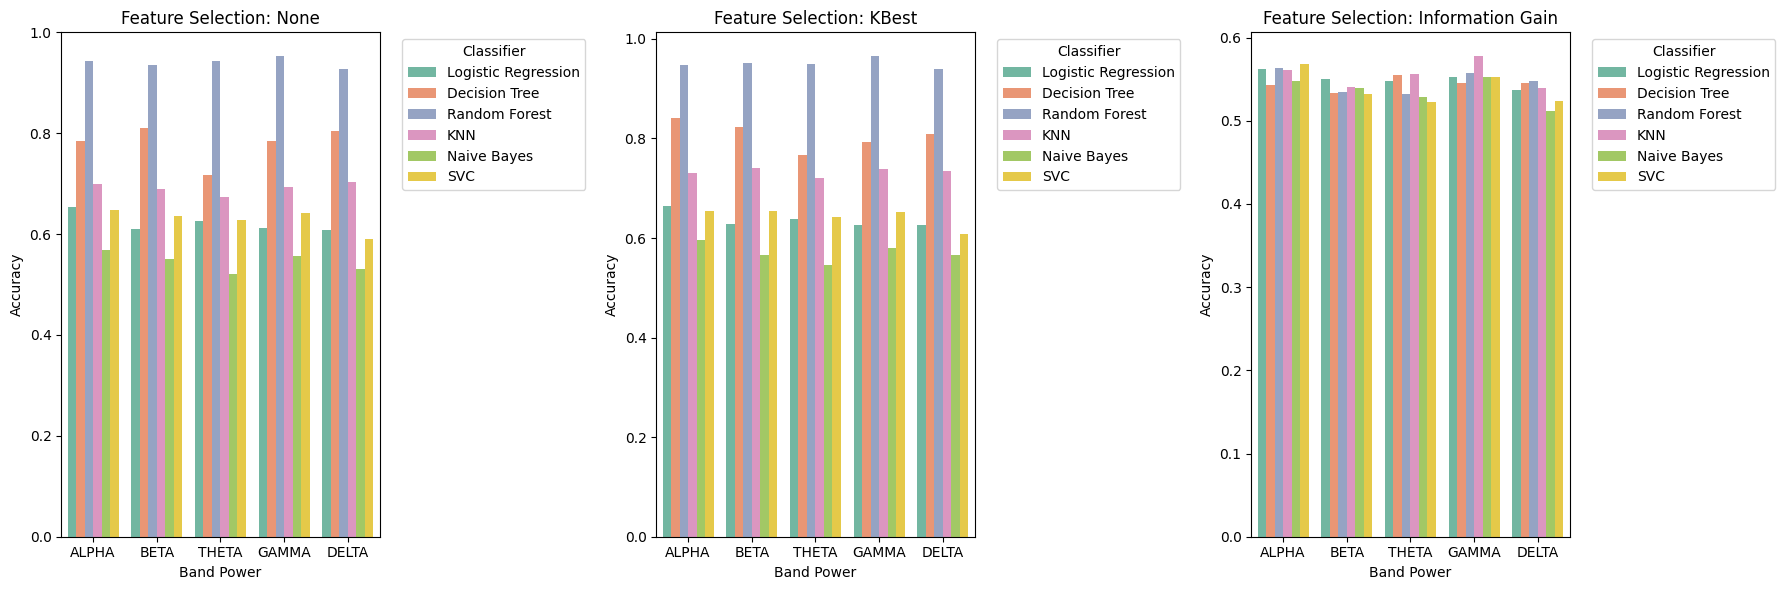

In [ ]:
accuracy_df["Feature Selection Method"] = "None"
accuracies_with_kbest["Feature Selection Method"] = "KBest"
accuracies_with_information_gain["Feature Selection Method"] = "Information Gain"
combined_df = pd.concat([accuracy_df, accuracies_with_kbest, accuracies_with_information_gain])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = ['None', 'KBest', 'Information Gain']
for i, method in enumerate(methods):
    method_data = combined_df[combined_df["Feature Selection Method"] == method]

    sns.barplot(x="Band Power", y="Accuracy", hue="Model", data=method_data, ci=None, palette="Set2", ax=axes[i])
    
    axes[i].set_title(f"Feature Selection: {method}")
    axes[i].set_xlabel("Band Power")
    axes[i].set_ylabel("Accuracy")
    axes[i].legend(title="Classifier", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()